# Download Dataset

In [ ]:
!git clone https://github.com/foxyhyun/NPL_Workshop_2026.git
%cd NPL_Workshop_2026


Cloning into 'NPL_Workshop_2026'...
remote: Enumerating objects: 1206, done.
remote: Total 1206 (delta 0), reused 0 (delta 0), pack-reused 1206 (from 1)
Receiving objects: 100% (1206/1206), 179.15 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (1201/1201), done.
/content/NPL_Workshop_2026


GT_DIR  : /content/NPL_Workshop_2026/data/GT
MASK_DIR: /content/NPL_Workshop_2026/data/Mask
Counts: GT = 300 | Mask = 300


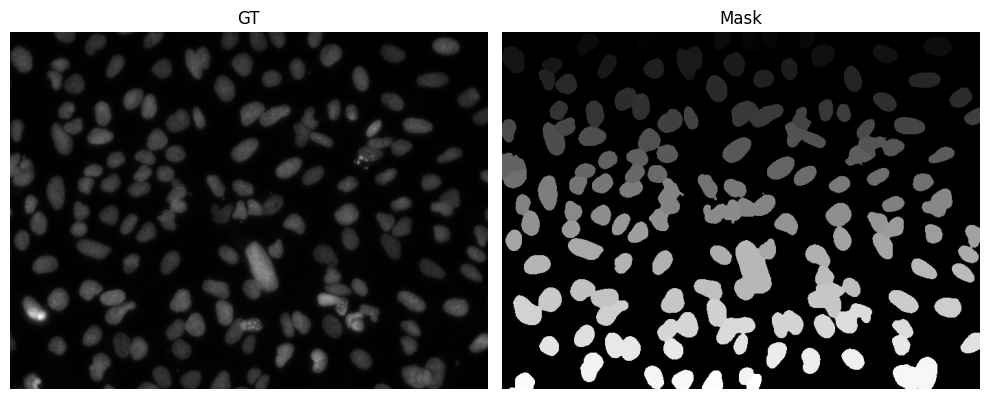

In [ ]:
import random, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

DATA_ROOT = Path("/content/NPL_Workshop_2026/data")
GT_DIR = DATA_ROOT / "GT"
MASK_DIR = DATA_ROOT / "Mask"

assert GT_DIR.exists(), f"GT folder not found: {GT_DIR}"
assert MASK_DIR.exists(), f"Mask folder not found: {MASK_DIR}"

gt_files = sorted(list(GT_DIR.glob("*.png")))
mask_files = sorted(list(MASK_DIR.glob("*.png")))

print("GT_DIR  :", GT_DIR)
print("MASK_DIR:", MASK_DIR)
print("Counts: GT =", len(gt_files), "| Mask =", len(mask_files))

def norm_key(name: str):
    stem = Path(name).stem
    stem = re.sub(r'_w\d+$', '', stem, flags=re.IGNORECASE)
    return stem.lower()

gt_map   = {norm_key(p.name): p for p in gt_files}
mask_map = {norm_key(p.name): p for p in mask_files}

common_keys = sorted(list(set(gt_map.keys()) & set(mask_map.keys())))

assert len(common_keys) > 0, "No matches even after removing _w#. Check patterns."

k = random.choice(common_keys)
gt_path = gt_map[k]
mask_path = mask_map[k]

gt = cv2.imread(str(gt_path), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

def to_u8(x):
    x = x.astype(np.float32)
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return (x * 255).astype(np.uint8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("GT");   plt.imshow(to_u8(gt), cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("Mask"); plt.imshow(to_u8(mask), cmap="gray"); plt.axis("off")
plt.tight_layout()
plt.show()



# Thresholding

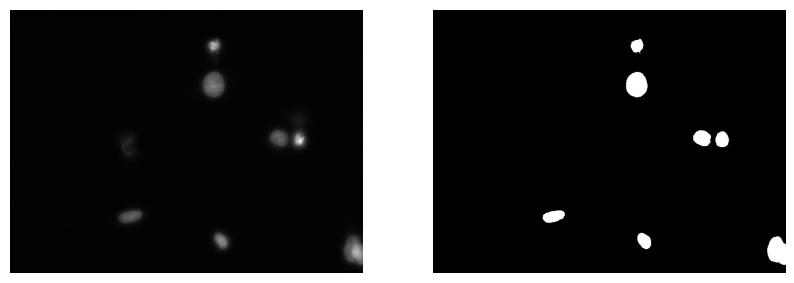

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === You can change this values ===
THR = 50       # 0 ~ 255
idx = 0     # 0 ~ 299
# ==================================

DATA_ROOT = Path("/content/NPL_Workshop_2026/data")
IN_DIR = DATA_ROOT / "GT"
files = sorted([f for f in os.listdir(IN_DIR)
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))])

img = cv2.imread(os.path.join(IN_DIR, files[min(max(idx, 0), len(files)-1)]), cv2.IMREAD_UNCHANGED)
if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_u8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

_, mask = cv2.threshold(img_u8, THR, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(img_u8, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.show()





# Otsu Thresholding

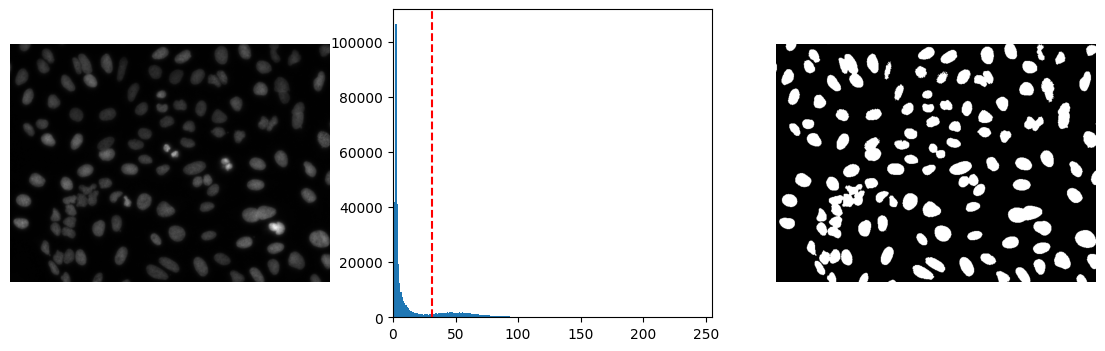

Otsu threshold: 31


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === You can change this values to select different samples ===
idx =  200 # 0 ~299
# ==================================

IN_DIR = DATA_ROOT / "GT"
files = sorted([f for f in os.listdir(IN_DIR)
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))])

img = cv2.imread(os.path.join(IN_DIR, files[min(max(idx, 0), len(files)-1)]), cv2.IMREAD_UNCHANGED)
if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_u8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

thr_otsu, mask = cv2.threshold(img_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(14, 4))

plt.subplot(1,3,1)
plt.imshow(img_u8, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.hist(img_u8.ravel(), bins=256)
plt.axvline(thr_otsu, color="red", linestyle="--")
plt.xlim(0, 255)

plt.subplot(1,3,3)
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()

print("Otsu threshold:", int(thr_otsu))



# Clustering with KMeans

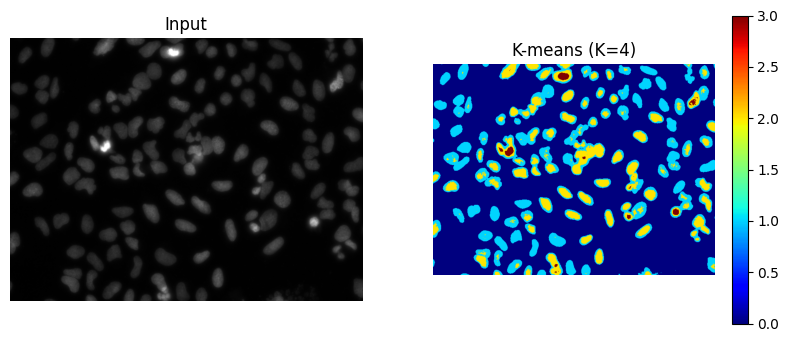

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.cluster import KMeans

img = imread('/content/NPL_Workshop_2026/data/GT/mcf-z-stacks-03212011_c18_s2_w1.png')

X = img.reshape(-1, 1).astype(np.float32)

# === You can change this value and check the different result
K = 4
n = 10
# ========
km = KMeans(n_clusters=K, n_init=n, random_state=0)
labels = km.fit_predict(X).reshape(img.shape)

centers = km.cluster_centers_.squeeze()
order = np.argsort(centers)
seg = np.zeros_like(labels)
for new_id, old_id in enumerate(order):
    seg[labels == old_id] = new_id

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Input'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(seg, cmap='jet'); plt.colorbar(); plt.title(f'K-means (K={K})'); plt.axis('off')
plt.show()



# U-Net

In [ ]:
import os, re, random
import numpy as np
import cv2
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Paths
# -------------------------
DATA_ROOT = Path("/content/NPL_Workshop_2026/data")
IN_DIR   = DATA_ROOT / "GT"
GT_DIR   = DATA_ROOT / "Mask"

assert IN_DIR.exists(), f"Input folder not found: {IN_DIR}"
assert GT_DIR.exists(), f"GT/Mask folder not found: {GT_DIR}"

# -------------------------
# Hyperparams
# You can choose this value
# -------------------------
IMG_SIZE = 256
EPOCHS = 20
LR = 0.001
BATCH_SIZE = 4

KERNEL_SIZE = 3
PADDING     = 1
BASE_CH     = 32
USE_BILINEAR_UPSAMPLE = False
# ------------------

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

SEED = 2026
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

def list_imgs(folder: Path):
    return sorted([p.name for p in folder.iterdir()
                   if p.is_file() and p.suffix.lower() in [".png",".jpg",".jpeg",".tif",".tiff"]])

def key_from_input(name):
    m = re.search(r"_([a-z]\d{2})_(s\d+)_w\d+", name.lower())
    return f"{m.group(1)}_{m.group(2)}" if m else Path(name).stem.lower()

def key_from_mask(name):
    m = re.search(r"_([a-z]\d{2})_(s\d+)$", Path(name).stem.lower())
    return f"{m.group(1)}_{m.group(2)}" if m else Path(name).stem.lower()

def build_pairs(in_dir: Path, gt_dir: Path):
    in_files = list_imgs(in_dir)
    gt_files = list_imgs(gt_dir)

    gt_map = {key_from_mask(g): g for g in gt_files}

    pairs = []
    for f in in_files:
        k = key_from_input(f)
        if k in gt_map:
            pairs.append((f, gt_map[k]))

    print(f"Input files: {len(in_files)} | Mask files: {len(gt_files)}")
    print(f"Matched pairs: {len(pairs)}")
    if pairs:
        print("Example pair:", pairs[0])
    return pairs

PAIRS = build_pairs(IN_DIR, GT_DIR)
assert len(PAIRS) > 0, "No pairs found. Check naming patterns."

def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Failed to read: {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    return img.astype(np.uint8)

class SegDataset(Dataset):
    def __init__(self, in_dir, gt_dir, pairs, img_size=256):
        self.in_dir, self.gt_dir = str(in_dir), str(gt_dir)
        self.pairs = pairs
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        in_name, gt_name = self.pairs[idx]

        x = read_gray(os.path.join(self.in_dir, in_name))
        y = cv2.imread(os.path.join(self.gt_dir, gt_name), cv2.IMREAD_GRAYSCALE)
        if y is None:
            raise ValueError(f"Failed to read mask: {gt_name}")

        x = cv2.resize(x, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)
        y = cv2.resize(y, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        x = (x / 255.0).astype(np.float32)[None, ...]   # [1,H,W]
        y = (y > 0).astype(np.float32)[None, ...]       # [1,H,W] binary
        return torch.from_numpy(x), torch.from_numpy(y)

dataset = SegDataset(IN_DIR, GT_DIR, PAIRS, img_size=IMG_SIZE)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# -------------------------
# U-Net
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out, k=3, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=k, padding=p),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, kernel_size=k, padding=p),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, c_in, c_out, k=3, p=1):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(c_in, c_out, k=k, p=p)
    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, c_in, c_out, k=3, p=1, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
            self.reduce = nn.Conv2d(c_in, c_in // 2, kernel_size=1)
        else:
            self.up = nn.ConvTranspose2d(c_in, c_in // 2, kernel_size=2, stride=2)
            self.reduce = nn.Identity()
        self.conv = DoubleConv(c_in, c_out, k=k, p=p)

    def forward(self, x, skip):
        x = self.reduce(self.up(x))
        if x.shape[-2:] != skip.shape[-2:]:
            x = torch.nn.functional.interpolate(x, size=skip.shape[-2:], mode="nearest")
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, base=32, k=3, p=1, bilinear=False):
        super().__init__()
        self.inc   = DoubleConv(1, base, k=k, p=p)
        self.down1 = Down(base, base*2, k=k, p=p)
        self.down2 = Down(base*2, base*4, k=k, p=p)
        self.down3 = Down(base*4, base*8, k=k, p=p)
        self.down4 = Down(base*8, base*16, k=k, p=p)

        self.up1 = Up(base*16, base*8, k=k, p=p, bilinear=bilinear)
        self.up2 = Up(base*8,  base*4, k=k, p=p, bilinear=bilinear)
        self.up3 = Up(base*4,  base*2, k=k, p=p, bilinear=bilinear)
        self.up4 = Up(base*2,  base,   k=k, p=p, bilinear=bilinear)

        self.outc = nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        d4 = self.up1(x5, x4)
        d3 = self.up2(d4, x3)
        d2 = self.up3(d3, x2)
        d1 = self.up4(d2, x1)

        return self.outc(d1)

model = UNet(base=BASE_CH, k=KERNEL_SIZE, p=PADDING, bilinear=USE_BILINEAR_UPSAMPLE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

for ep in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()

    print(f"Epoch {ep:02d} | Loss: {total / len(train_loader):.4f}")



DEVICE: cuda
Input files: 300 | Mask files: 300
Matched pairs: 300
Example pair: ('mcf-z-stacks-03212011_a01_s1_w1.png', 'mcf-z-stacks-03212011_a01_s1.png')
Epoch 01 | Loss: 0.3348
Epoch 02 | Loss: 0.0954
Epoch 03 | Loss: 0.0822
Epoch 04 | Loss: 0.0687
Epoch 05 | Loss: 0.0778
Epoch 06 | Loss: 0.0875
Epoch 07 | Loss: 0.0881
Epoch 08 | Loss: 0.0739
Epoch 09 | Loss: 0.0704
Epoch 10 | Loss: 0.0648
Epoch 11 | Loss: 0.6681
Epoch 12 | Loss: 0.1350
Epoch 13 | Loss: 0.0968
Epoch 14 | Loss: 0.0728
Epoch 15 | Loss: 0.0623
Epoch 16 | Loss: 0.0559
Epoch 17 | Loss: 0.0509
Epoch 18 | Loss: 0.0670
Epoch 19 | Loss: 0.0491
Epoch 20 | Loss: 0.0452


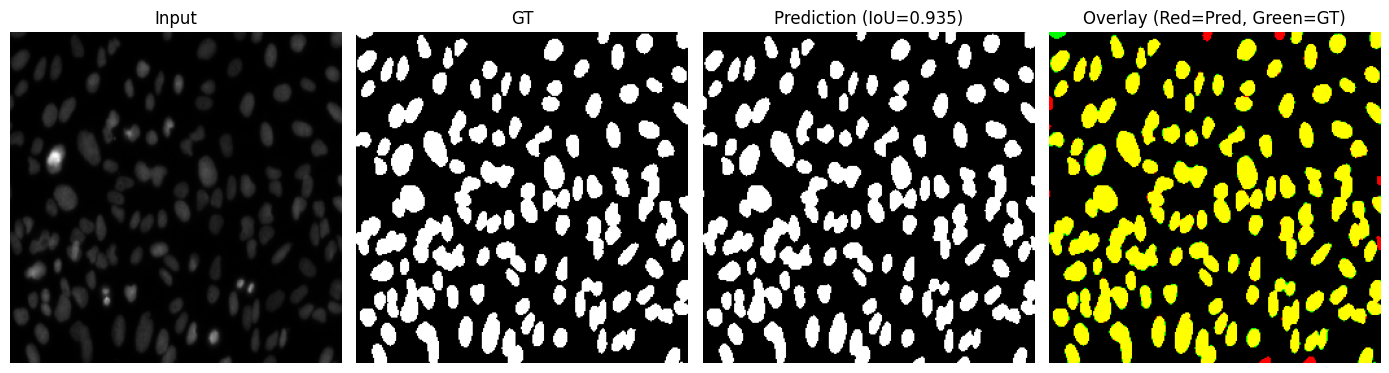

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def compute_iou(gt_bin, pred_bin):
    inter = np.logical_and(gt_bin, pred_bin).sum()
    union = np.logical_or(gt_bin, pred_bin).sum()
    return float(inter) / float(union + 1e-8)

def make_overlay(gt_bin, pred_bin):
    """
    RGB overlay:
      - GT only    : Green
      - Pred only  : Red
      - Overlap    : Yellow (R+G)
    """
    h, w = gt_bin.shape
    overlay = np.zeros((h, w, 3), dtype=np.float32)

    gt_only   = np.logical_and(gt_bin == 1, pred_bin == 0)
    pred_only = np.logical_and(gt_bin == 0, pred_bin == 1)
    overlap   = np.logical_and(gt_bin == 1, pred_bin == 1)

    overlay[gt_only,   1] = 1.0
    overlay[pred_only, 0] = 1.0
    overlay[overlap,   0] = 1.0
    overlay[overlap,   1] = 1.0
    return overlay

@torch.no_grad()
def show_one(model, dataset, idx=100, thr=0.5, device="cuda"):
    model.eval()

    x, y = dataset[idx]
    xB = x.unsqueeze(0).to(device)

    logits = model(xB)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    pred = (prob > thr).astype(np.uint8)

    gt = y[0].numpy().astype(np.uint8)

    iou = compute_iou(gt == 1, pred == 1)
    overlay = make_overlay(gt, pred)

    plt.figure(figsize=(14,4))

    plt.subplot(1,4,1)
    plt.title("Input")
    plt.imshow(x[0].numpy(), cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("GT")
    plt.imshow(gt, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title(f"Prediction (IoU={iou:.3f})")
    plt.imshow(pred, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("Overlay (Red=Pred, Green=GT)")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_one(model, dataset, idx=100, thr=0.5, device=DEVICE)


In [ ]:
!pip install cellpose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 57.7 MB/s eta 0:00:00


OFO  : mcf-z-stacks-03212011_c08_s2_w1.png
CLEAN: mcf-z-stacks-03212011_c08_s2_w1.png


100%|██████████| 1.15G/1.15G [00:05<00:00, 213MB/s]


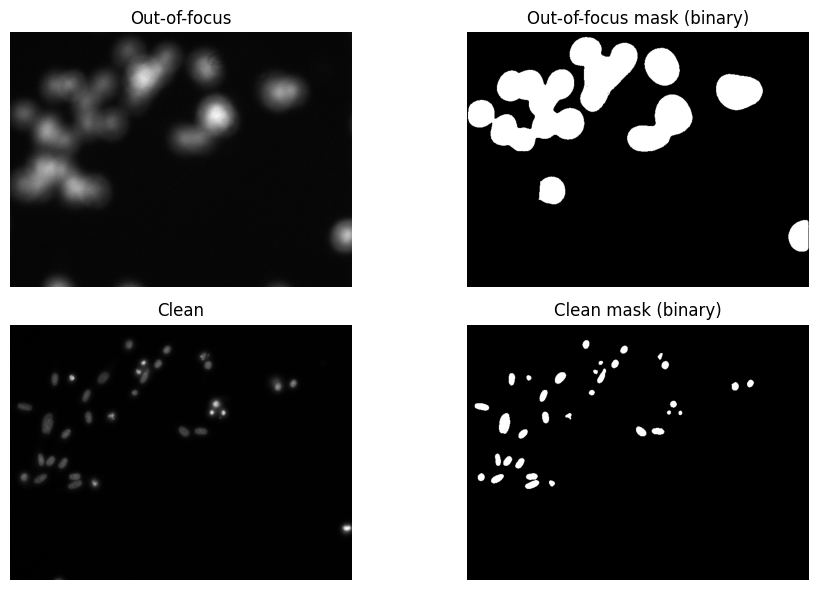

In [ ]:
import os
import matplotlib.pyplot as plt

OFO_DIR   = "/content/NPL_Workshop_2026/data/Input"
CLEAN_DIR = "/content/NPL_Workshop_2026/data/GT"

i = 50  # 0 ~ 300

exts = (".tif", ".tiff", ".png", ".jpg", ".jpeg")
ofo_list   = sorted([f for f in os.listdir(OFO_DIR)   if f.lower().endswith(exts)])
clean_list = sorted([f for f in os.listdir(CLEAN_DIR) if f.lower().endswith(exts)])

ofo_path   = os.path.join(OFO_DIR,   ofo_list[i])
clean_path = os.path.join(CLEAN_DIR, clean_list[i])

print("OFO  :", ofo_list[i])
print("CLEAN:", clean_list[i])

from cellpose import models, io
img_ofo   = io.imread(ofo_path)
img_clean = io.imread(clean_path)

if img_ofo.ndim == 3:   img_ofo = img_ofo[0]
if img_clean.ndim == 3: img_clean = img_clean[0]

model = models.CellposeModel(gpu=True)
m_ofo,   _, _ = model.eval(img_ofo, diameter=30)
m_clean, _, _ = model.eval(img_clean, diameter=30)

bin_ofo   = (m_ofo > 0).astype(int)
bin_clean = (m_clean > 0).astype(int)

plt.figure(figsize=(10,6))
plt.subplot(2,2,1); plt.title("Out-of-focus"); plt.imshow(img_ofo, cmap="gray"); plt.axis("off")
plt.subplot(2,2,2); plt.title("Out-of-focus mask (binary)"); plt.imshow(bin_ofo, cmap="gray"); plt.axis("off")
plt.subplot(2,2,3); plt.title("Clean"); plt.imshow(img_clean, cmap="gray"); plt.axis("off")
plt.subplot(2,2,4); plt.title("Clean mask (binary)"); plt.imshow(bin_clean, cmap="gray"); plt.axis("off")
plt.tight_layout(); plt.show()
